## Loading datasets

In [21]:
import os

import torch
import torch.nn.functional as F
import numpy as np

from utils.dataset import TrainMultiDataset
from utils.mask import tensor_arr_dist_circle_mask, tensor_img_dist_circle_mask 
from utils.optical_flow.spynet import spynet_optical_flow 
from utils.optical_flow.farneback import farneback_optical_flow
from utils.img_optic_vis import show_imgs, show_farneback_optical_flows, save_spynet_optical_flows

# Dataset and Loader
dataset_test = TrainMultiDataset(
    [os.path.join('data/same_vis_same_phys/train/', fp) for fp in os.listdir('data/same_vis_same_phys/train/')],
    img_size=(256, 256),
    buffer_size=3,
    random_order=True)
 
loader_train = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=4,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    drop_last=True,
    num_workers=2,
    pin_memory=True)

# create loader iterator
iterator_train = iter(loader_train)

In [6]:
output = iterator_train.next()

In [7]:
output['img_data'].shape

torch.Size([4, 3, 3, 256, 256])

## Metres to pixel based masking

In [8]:
# px_per_m calculation
q = 55.0 * np.pi / 180
focal_length = 256.0 / np.tan(q/2)
px_per_m = focal_length * 1/2
m_per_px = 1 / px_per_m

In [9]:
# backtracking 256 px_per_m to q
focal_length = 2 * 256
q = np.arctan(256.0 / focal_length) * 2 * 180 / np.pi

## Testing images and optical flow

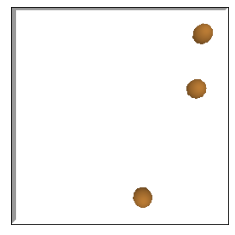

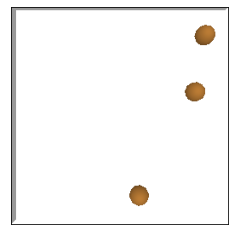

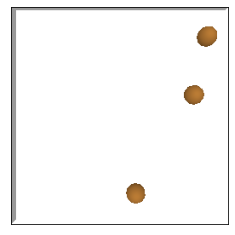

In [10]:
for i in range(len(output['img_data'][0])):
    show_imgs([output['img_data'][0, i]])

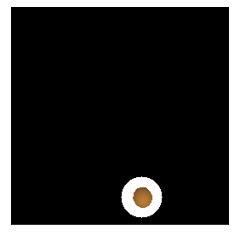

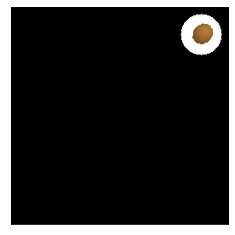

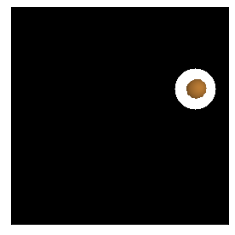

In [11]:
for cx,cy,cr in output['state_label'][0][0][:, [0,1,-2]].detach().numpy():
    show_imgs([tensor_img_dist_circle_mask(output['img_data'][0][0], cx, cy, cr + 0.05)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


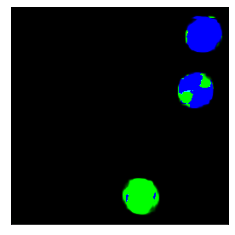

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


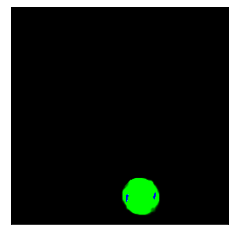

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


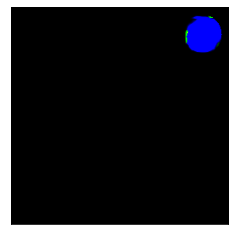

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


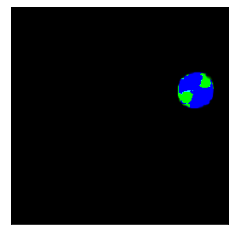

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


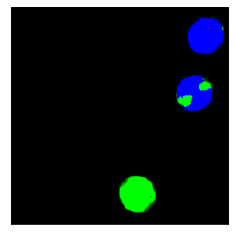

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


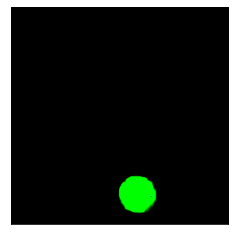

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


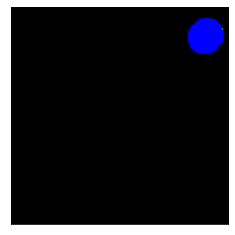

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


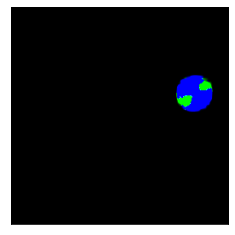

In [12]:
opt_flow_masks = []
cxs = []
cys = []
crs = []

for i in range(2):
    opt_flow = farneback_optical_flow(output['img_data'][0][i], output['img_data'][0][i+1])
    opt_flow_masks.append(opt_flow)
    
    for j in range(3):
        cx = output['state_label'][0][i][j, 0]
        cy = output['state_label'][0][i][j, 1]
        cr = output['state_label'][0][i][j, -2]
        
        cxs.append(cx)
        cys.append(cy)
        crs.append(cr)    
        opt_flow_masks.append(tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1))

for i in range(len(opt_flow_masks)):
    show_farneback_optical_flows([opt_flow_masks[i]])

In [13]:
opt_flow_masks = []
cxs = []
cys = []
crs = []

for i in range(2):
    opt_flow = spynet_optical_flow(output['img_data'][0][i], output['img_data'][0][i+1])
    opt_flow_masks.append(opt_flow)
    
    for j in range(3):
        cx = output['state_label'][0][i][j, 0]
        cy = output['state_label'][0][i][j, 1]
        cr = output['state_label'][0][i][j, -1]
        
        cxs.append(cx)
        cys.append(cy)
        crs.append(cr)    
        opt_flow_masks.append(tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1))

#save_spynet_optical_flows(opt_flow_masks)

In [14]:
input_data = output['img_data']
output_data = output['state_label']

BA, BU, C, H, W = input_data.shape
_, _, num_balls, num_features = output_data.shape
processed_output_data = output_data

C_Final = BU * 3 + (BU - 1) * 2
input_processed = torch.zeros(BA * num_balls, C_Final, H, W)
assert BU == 3
for i in range(BA):
    for j in range(BU):
        img_orig = input_data[i, j, ...]
        for k in range(num_balls):
            cx, cy, cr = output_data[i, j, k, [0, 1, -2]]
            img_masked = tensor_img_dist_circle_mask(img_orig, cx, cy, cr+0.05)
            input_processed[i + k, j * 3:(j + 1) * 3, ...] = img_masked
            if j != BU-1:
                opt_flow = farneback_optical_flow(input_data[i][j], input_data[i][j+1])
                opt_flow_masked = tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1)
                input_processed[i + k, BU*3 + j*2:BU*3 + (j+1)*2, ...] = opt_flow_masked

In [15]:
#for i in range(BA):
#    print(f'batch {i}')
#    for k in range(num_balls):
#        print(f'ball {k}')
#        for j in range(BU):
#            print(f'buffer {j}')
#            masked_img = input_processed[i + k, j * 3:(j + 1) * 3, ...]
#            show_imgs([masked_img])
#            if j != BU-1:
#                opt_flow_masked = input_processed[i + k, BU*3 + j*2:BU*3 + (j+1)*2]
#                show_farneback_optical_flows([opt_flow_masked])

### labelling function

In [46]:
label = torch.zeros(1000, dtype=torch.long)
label[:] = 0

output = torch.rand(1000,9)

pred_log_prob = F.log_softmax(output, dim=1)
preds = torch.argmax(output, dim=1)
valid = (label >= 0).long()
acc_sum = torch.sum(valid * (preds == label).long())
valid_sum = torch.sum(valid)
acc = acc_sum.float() / (valid_sum.float() + 1e-10)
#print(label)
#print(preds)
print(acc)

tensor(0.1190)
